In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw4.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 4: Convolutional Neural Networks


**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import os
import pathlib
import time
import zipfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
import csv
import pandas as pd

%matplotlib inline

2023-04-05 22:19:18.748751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:19:18.869668: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/opt/conda/envs/cs109b/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# measure notebook runtime
time_start = time.time()

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

**Please run these cells below.** First we set our local working directory to ensure our provided code in PART 2 works correctly, and then we enable [TensorFlow eager execution](https://www.tensorflow.org/guide/eager) and print a summary of whether there are local GPUs available for training your models. Running this HW on JupyterHub is recommended. But as long as you are using the provided `cs109b.yml` conda environment, you should expect to see a TensorFlow version >=2.3.0, which should allow this notebook to run without error.

In [5]:
# RUN THIS CELL

working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)

In [6]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.11.0
keras version 2.11.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2023-04-05 22:19:21.442477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 22:19:21.448282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 22:19:21.448534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 22:19:21.449561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati


<a id="contents"></a>

## Notebook Contents

- [**PART 1 [55 pts]: Building a Basic CNN Model**](#part1)

- [**PART 2 [45 pts]: Regression with CNN**](#part2)


## About this Homework

In this homework, we will explore Convolutional Neural Networks (CNNs).

- In [PART 1](#part1), we will begin by building a CNN to classify CIFAR-10 images, a standard pedagogical problem, and use saliency maps to understand where the network is placing its "attention."


- Then, in [PART 2](#part2), we will then see that CNNs are great for more than just classifying our images! They can serve as image input processing for a variety of tasks, as we will show by training a network on the CelebA dataset to rotate images of faces upright.

**IMPORTANT NOTES:**

- Convolutional neural networks are computationally intensive.
- **We highly recommend that you train your model on a system using GPUs. For this, we recommend using the GPU-enabled JupyterHub environment provided to you as part of this course** (or you could also take a look at Google Colab's runtime settings for accessing a GPU-enabled environment free of cost).
- Models that take hours to train on CPUs can be trained in just minutes when using GPUs.
- Additionally, **if you become frustrated having to rerun your model every time you open your notebook, take a look at how to save your trained model weights for later use** (as is required in [PART 2, question 2.2.3](#q223)).

**KERNEL CRASHES:**

If your kernel crashes as you attempt to train your model, please check the following items:
- Models with too many parameters might not fit in GPU memory. Try reducing the size of your model.
- A large `batch_size` will attempt to load too many images in GPU memory. Avoid using a very large batch size.
- Avoid creating multiple copies of the data.

<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [55 pts]: Building a Basic CNN Model


<a id="part1intro"></a>

## Overview

[Return to contents](#contents)

In this question, you will use Keras to create a convolutional neural network for predicting the "type of object" shown in each image from the [CIFAR-10](https://keras.io/datasets/#cifar10-small-image-classification) dataset. This dataset contains 50,000 32x32 colored training images and 10,000 test images of the same size, with a total of 10 classes, representing the "type of object" shown in each image.

<a id="q11"></a>



<!-- BEGIN QUESTION -->

<div class='exercise'>
    
<b>1.1 Loading CIFAR-10 and Constructing the Model</b>
<hr>
<b>Q1.1.1 - Preprocessing</b>

<a id="q111"></a>

Load the CIFAR-10 dataset from the `tensorflow.keras.datasets.cifar10` import shown at the top of this notebook. Perform any preprocessing of the data that might be required for this dataset.
    
You may choose to load cifar10 as either a numpy array or as a Tensorflow Dataset.
</div>

In [7]:
# your code here
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [8]:
# Normalize the training and testing data
X_train, X_test = normalize(X_train), normalize(X_test)

# Convert the training and testing labels to categorical data
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

print(X_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000, 10)


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1.2</b>

<a id="q112"></a>

Construct a classification model architecture using a combination of the following layers: Conv2D, MaxPooling2D, Dense, Dropout and Flatten. The layers don’t necessarily need to be in this order, and you can use as many of these types of layers as you’d like. 

  - You may choose to construct your own implementation of a well-known architecture like AlexNet or VGG16, or you can create an architecture of your own devising.

  - However, you MUST code the network yourself and not use a pre-written implementation. 

  - You must have at least 2 Conv2D layers, and at least one of your Conv2D layers should have 9 or more filters in order to complete question 1.4.1.

</div>

**Approach**

The approach we aim to implement involves using a convolutional neural network to decrease the width and height dimensions while increasing the number of channels to extract features. The resulting output will serve as an appropriate input for a fully connected network that performs the classification task. This strategy is inspired from the article published on Towards Data Science, which describes image classification on the CIFAR-10 dataset using TensorFlow. https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

The `ConvNet` model consists of multiple layers of convolutional and pooling operations, which are used to extract relevant features from the input images. These layers are followed by fully connected (dense) layers for classification.

The `Conv2D` layers represent the convolutional layers, which use filters to scan the input images and identify features such as edges, textures, and shapes. The `MaxPooling2D` layers represent the pooling layers, which reduce the spatial dimensions of the feature maps and help to prevent overfitting.

The `Flatten` layer is used to reshape the output of the convolutional and pooling layers into a 1D array, which can be fed into the fully connected layers. The `Dense` layers represent the fully connected layers, which learn to classify the images based on the extracted features.

The `Dropout` layers are used to regularize the model and prevent overfitting by randomly dropping out a fraction of the input units during training.

Finally, the `softmax` activation function is used in the output layer to normalize the predicted probabilities of the 10 classes and ensure that they sum to 1.

In [9]:
# your code here

# Get the input shape of the training data
input_shape = X_train.shape[1:]

# Set the values of convolutional size, pool size and initial filters
convolution_size = 3
pool_size = (2,2)
initial_filters = 32

# Define a function to create the Convolutional Neural Network (ConvNet) model
def convnet(input_shape, convolution_size, pool_size, initial_filters):
    
    # Define the input layer of the ConvNet
    inputs = Input(input_shape)
    
    # Add convolutional layers to extract features from the input
    x = Conv2D(initial_filters, 3, activation="relu")(inputs)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Conv2D(initial_filters*2, 3, activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Conv2D(initial_filters*4, 3, activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    
    # Flatten the output to prepare it for the fully connected layer
    x = Flatten()(x)
    
    # Add dense layers for classification
    x = Dense(initial_filters*16, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(initial_filters*16, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Define the output layer of the ConvNet
    outputs = Dense(10, activation="softmax")(x)
    
    # Define the model architecture
    model = Model(inputs=inputs, outputs=outputs, name="ConvNet")
    
    return model

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2 Model parameter growth</b>

<a id="q12"></a>

How does the number of total parameters change (e.g. linearly, exponentially, etc.) as the number of filters per layer increases (your model should have at least 2 Conv layers)? You can find this empirically by constructing multiple models with the same type of architecture and increasing the number of filters. Generate a plot showing the relationship and explain why it has this relationship. 

**HINT:** Completing this question is far easier if you write a function that generates your desired architecture in 1.1.2, with arguments that allow you to easily rebuild the architecture with varying numbers of filters per layer.
    </div>

**Explanation**

When using the implemented architecture to construct a model, increasing the number of filters by a factor of $n$ results in an increase of $O(n)$ filters in each convolutional layer. This means that the total number of filters in the model increases linearly with the increase in the number of filters.

In addition, the number of parameters in the dense layers of the model increases polynomially with the number of parameters in the previous layer, as each parameter in a dense layer is connected to all the parameters in the previous layer. This leads to a polynomial increase in the total number of parameters in the model with respect to the number of filters.

As a result, when we increase the number of filters in the model, the total number of parameters increases polynomially with the degree of the polynomial being the number of dense layers in the model. This can be observed from the plot of the total number of parameters versus the number of filters, which shows a polynomial increase with the degree being equal to the number of dense layers in the model.

Mathematically, we can represent the increase in the number of parameters in the dense layers as follows:

Let $N$ be the number of parameters in a dense layer and $M$ be the number of parameters in the previous layer. Then, we can express $N$ as a polynomial function of $M$ as:

$N = aM^b + c$

where $a$, $b$, and $c$ are constants that depend on the specific architecture and hyperparameters of the model. The degree of the polynomial function is $b$, which is equal to the number of dense layers in the model.

Therefore, when we increase the number of filters in the model, we can expect the total number of parameters to increase polynomially with the degree of the polynomial being the number of dense layers in the model.

In [10]:
# your code here

# Create a function to compute the number of parameters in a network

def get_params(network):
    # Calculate the total number of trainable parameters in the network.
    train_params = np.sum([np.prod(layer.get_shape()) for layer in network.trainable_weights])
    # Calculate the total number of non-trainable parameters in the network.
    non_train_params = np.sum([np.prod(layer.get_shape()) for layer in network.non_trainable_weights])
    # Return the sum of the trainable and non-trainable parameters.
    return train_params + non_train_params

In [11]:
num_filters = [10*i for i in range(1,30)]
n_params = [get_params(convnet(input_shape, convolution_size, pool_size, k)) for k in num_filters]

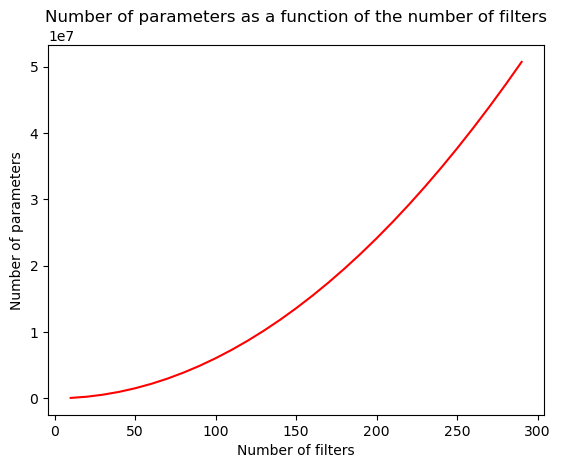

In [12]:
plt.plot(num_filters, n_params, color='red')
plt.xlabel('Number of filters')
plt.ylabel('Number of parameters')
plt.title('Number of parameters as a function of the number of filters');

<a id="q13"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>

<b>1.3 Choose a model, train and evaluate it</b>
<hr>    
<b>Q1.3.1</b>

<a id="q131"></a>

Print the model summary for your chosen architecture, and report the total number of parameters. Then train your model using the CIFAR-10 dataset, and `validation_split=0.2`. You can choose to train your model for as long as you'd like, but you should aim for at least 10 epochs. Report your validation and test accuracies. They should both exceed 70%.

**Hint:** It would be helpful to add code which either saves your model to a local directory if it is the first time you're training it or loads your model if a saved file version currently exists in that directory. This will not only help save time when you rerun your notebook, but it will also ensure reproducible results in the rest of Part 1.
</div>

**Answer to Q1.3.1**

Number of parameters: 623690.0

As we are not using early-stopping and patience, we can just take the validation scores of the last epoch of our training history:
- Validation accuracy: 0.7146999835968018
- Test accuracy: 0.7103999853134155 

In [13]:
# your code here

# We start by checking the number of parameters in our current architecture
convnet1 = convnet(input_shape, convolution_size, pool_size, initial_filters)
convnet1.summary()
print(f"The total number of parameters is: {get_params(convnet1)}")

Model: "ConvNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_87 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 4, 4, 128)         7385

**We use this code to train the model, then comment it out and use the saved weights from this training in order to avoid re-training it across runs**

In [14]:
# your code here 
# convnet1.compile(optimizer='adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])

# Train the model 
# epochs = 42
# history = convnet1.fit(X_train, y_train, 
#                         epochs=epochs, 
#                         validation_split=0.2)

We save the model's history as a CSV file and then read it back into a dataframe to extract the relevant metrics. 

In [15]:
# define the file name and location
filename_train_hist = 'training_history.csv'

# # open the file for writing
# with open(filename, 'w', newline='') as csvfile:
#     # create a csv writer object
#     writer = csv.writer(csvfile)

#     # write the header row
#     writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])

#     # write the data rows
#     for i, (loss, val_loss, acc, val_acc) in enumerate(zip(history.history['loss'], 
#                                              history.history['val_loss'], 
#                                              history.history['accuracy'], 
#                                              history.history['val_accuracy'])):
#         writer.writerow([i+1, loss, val_loss, acc, val_acc])

In [16]:
# # Save model weights
# convnet1.save_weights('models/convnet1')

In [17]:
convnet1 = convnet(input_shape, convolution_size, pool_size, initial_filters)

In [18]:
# Load saved weights
convnet1.load_weights('models/convnet1')

In [19]:
# your code here 
convnet1.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [20]:
# read the CSV file into a Pandas DataFrame
history_df = pd.read_csv(filename_train_hist)
history_df = history_df.set_index('Epoch')

In [21]:
# your code here

# Evaluate model on test data
test_acc = convnet1.evaluate(X_test, y_test)[1]
val_acc = list(history_df['Validation Accuracy']).pop()

print('Validation accuracy:', val_acc)
print('Test accuracy:', test_acc)

2023-04-05 22:19:28.119100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


 23/313 [=>............................] - ETA: 0s - loss: 1.2205 - accuracy: 0.7228  

2023-04-05 22:19:28.781519: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


313/313 [==============================] - 3s 2ms/step - loss: 1.2910 - accuracy: 0.7104
Validation accuracy: 0.7146999835968018
Test accuracy: 0.7103999853134155


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.3.2</b>

<a id="q132"></a> 

Plot the training loss and accuracy per epoch (both train and validation) for your chosen architecture.

</div>

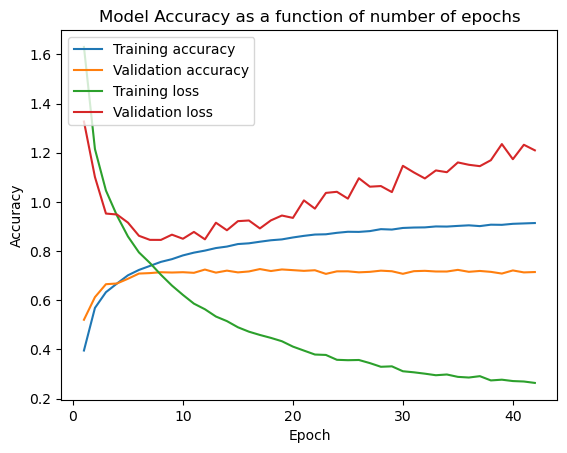

In [22]:
# your code here

plt.plot(history_df['Training Accuracy'],label="Training accuracy")
plt.plot(history_df['Validation Accuracy'],label= "Validation accuracy")

plt.plot(history_df['Training Loss'],label="Training loss")
plt.plot(history_df['Validation Loss'],label= "Validation loss")


plt.title('Model Accuracy as a function of number of epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left');

<a id="q14"></a> 


<!-- BEGIN QUESTION -->

<div class='exercise'>
    
<b>1.4 Techniques to visualize the model</b>
 
We will gain an intuition into how our model is processing the inputs in two ways.  First we'll ask you to use activation maps to visualize the activations in the intermediate layers of the network. We've provided a helper function `get_activation_maps` to aid in extracting activation maps from layer outputs in your model network.  Feel free to take advantage of it if you'd like.  We'll also ask you to use [saliency maps](https://arxiv.org/abs/1312.6034) to visualize the pixels that have the largest impact on the classification of an input (image in this case), including a more recent development, a [Grad-CAM](https://arxiv.org/abs/1610.02391) saliency heatmap, which has been shown to better indicate the attention of CNNs.
    
<hr>    
<b>Q1.4.1</b>

 
<a id="q141"></a> 

For a given input image from the test set that is correctly classified, use your model and extract 9 activation maps from an intermediate convolutional layer of your choice and plot the images in a 3x3 grid (use `imshow`'s `cmap='gray'` to show the activation maps in black & white).  Make sure to plot (and clearly label) your original input image as well. You may use the provided `get_activation_maps` function and the `cifar10dict` dictionary to convert class index to the correct class name.
    </div>

In [23]:
# RUN THIS CELL

# A helper function to generate activation maps

def get_activation_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing
    an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): activation map stacked output by the
        specified layer
    """
    model_ = Model(
        inputs=[model.input], outputs=[model.layers[layer_id].output]
    )
    return model_.predict(
        np.expand_dims(input_image, axis=0)
    )[0,:,:,:].transpose((2,0,1))


# A dictionary to turn class index into class labels for CIFAR-10

cifar10dict = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

1/1 [==============================] - 0s 36ms/step


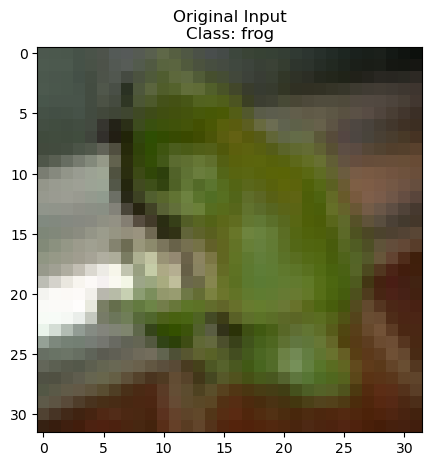

In [24]:
# Choose the ID to retrieve frog image
idx = 7
prediction = np.argmax(y_test[idx])

# Define the layer ID from which to extract activation maps
layer_id = 2

# Select a correctly classified image from the test set
input_image = X_test[idx]

# Get the predicted class index and class name
pred_class_idx = np.argmax(convnet1.predict(np.expand_dims(input_image, axis=0)))

# Assertion statement needs to be passed to make sure we are getting correct prediction
assert (pred_class_idx == np.argmax(y_test[idx]))

# Use dictionary to obtain predicted class name
pred_class_name = cifar10dict[pred_class_idx]

# Get the activation maps from the selected convolutional layer
maps = get_activation_maps(convnet1, layer_id, input_image)

# Plot the input image
plt.figure(figsize=(5, 5))
plt.imshow(input_image)
plt.title(f"Original Input\nClass: {pred_class_name}");

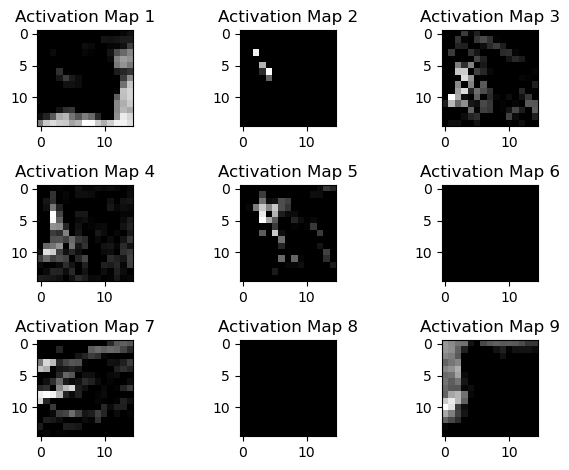

In [25]:
# Plot the activation maps in a 3x3 grid
for i in range(3):
    for j in range(3):
        map_idx = i * 3 + j
        if map_idx < maps.shape[0]:
            plt.subplot(3, 3, map_idx+1)
            plt.imshow(maps[map_idx], cmap='gray')
            plt.title(f"Activation Map {map_idx+1}")

# Adjust subplot spacing and show the plot
plt.tight_layout()
plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4.2</b>

<a id="q142"></a> 

For the same input image generate and plot a SmoothGrad saliency map to show the pixels in the image most pertinent to classification, and a Grad-CAM saliency heatmap. This is most easily done with the [tf-keras-vis](https://pypi.org/project/tf-keras-vis/) package. Take a look at the "Usage" examples; it will be straightforward to apply to our model. Feel free to pick your own [colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html); however, please stick to "perceptionally uniform sequential" or "sequential" colormaps because they are far easier to interpret (`jet` is neither). Arrange the three plots in a row using subplots: Original Image, SmoothGrad saliency Map, Grad-CAM saliency heatmap. Which visualization is easier to understand in your case, and what does the network seem to be focusing on?
    </div>

**Answer to 1.4.2**

SmoothGrad seems to be easier to understand in this case. It seems to be focusing on the shape of the frog's body whilst GradCam only focuses on the top/head region. This could create confusion as many animals have a similar looking head, such as snakes for example. 

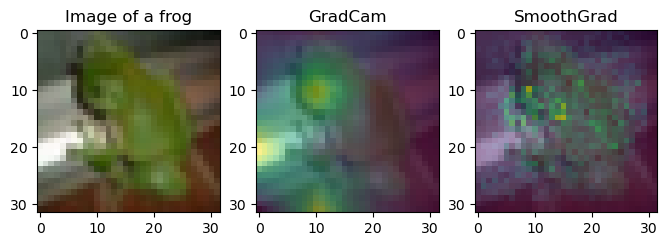

In [30]:
score = lambda x: x[:, prediction]

saliency = Saliency(convnet1)
saliency_map = saliency(score,
                        input_image,
                        smooth_samples=20,
                        smooth_noise=0.20)

gradcam = Gradcam(convnet1)
cam = gradcam(score,
              input_image,
              penultimate_layer=-1)

fig, axes = plt.subplots(1, 3, figsize=(8, 8))
axes = axes.flatten().tolist()

# Set up the input image as the background for the GradCam and SmoothGrad maps
background = input_image

ax = axes.pop(0)
ax.imshow(background)
ax.title.set_text("Image of a " + cifar10dict[prediction])

ax = axes.pop(0)
ax.imshow(background)
ax.imshow(cam[0], alpha=0.5)
ax.title.set_text("GradCam")

ax = axes.pop(0)
ax.imshow(background)
ax.imshow(saliency_map[0], alpha=0.5)
ax.title.set_text("SmoothGrad")


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.4.3</b>

<a id="q143"></a> 

Repeat 1.4.2, but for an image from the test set that is **incorrectly classified**, indicating both the incorrect label and what the correct label should be, and from the visualizations of network attention, hypothesize why the network arrived at its answer. (Make sure you pass a new loss to the visualizers that uses the **incorrect** class index, because we want to see what caused the network to think the image was in that category!) If you had control over what images go in the training dataset, how could you modify it to avoid this particular network failure?
    </div>

We choose to manually find an image of the dog that was incorrectly classified as opposed to iterating through the test set and compare the predictions as the classification of the dog is particularly problematic in this case. 

The model incorrectly classifies here the dog as a horse. We assume that this is due to the elongated shape of the dog's silhouette. The various maps depict this, for example SmoothGrad gives us an elongated blob which means that the network is overly focused on the dog's shape as opposed to discriminative features that would enable it to distinguish better between classes. GradCam too focuses on features in the north-east of the picture, which are not particularly deterministic either. 

A potential remedy to this issue is to filter between images where the dog's distinctive features are more separated from its body (ears, head, etc.). This would help the network avoid any confusions. 

In [31]:
idx2 = 85
prediction_2 = np.argmax(convnet1.predict(X_test[idx2].reshape(1,32,32,3))) 
true_2 = np.argmax(y_test[idx2])
assert  true_2 != prediction_2
score = lambda x: x[:, prediction_2]

1/1 [==============================] - 0s 18ms/step


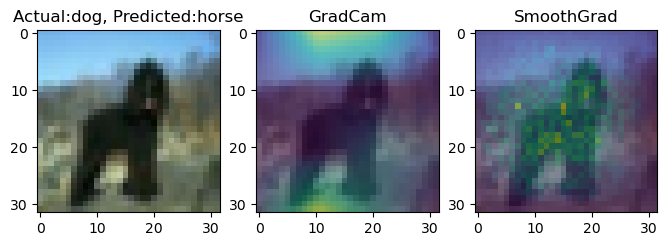

In [34]:
input_image = X_test[idx2]
score = lambda x: x[:, prediction]

saliency = Saliency(convnet1)
saliency_map = saliency(score,
                        input_image,
                        smooth_samples=20,
                        smooth_noise=0.20)

gradcam = Gradcam(convnet1)
cam = gradcam(score,
              input_image,
              penultimate_layer=-1)

fig, axes = plt.subplots(1, 3, figsize=(8, 8))
axes = axes.flatten().tolist()

# Set up the input image as the background for the GradCam and SmoothGrad maps
background = input_image

ax = axes.pop(0)
ax.imshow(background)
ax.title.set_text("Actual:"+ cifar10dict[true_2]+ ", Predicted:"+cifar10dict[prediction_2])

ax = axes.pop(0)
ax.imshow(background)
ax.imshow(cam[0], alpha=0.5)
ax.title.set_text("GradCam")

ax = axes.pop(0)
ax.imshow(background)
ax.imshow(saliency_map[0], alpha=0.5)
ax.title.set_text("SmoothGrad")

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [45 pts]: Regression with CNN 
<a id="part2intro"></a>
## Overview

[Return to contents](#contents)

**In this problem we will construct a neural network to predict how far a face is from being "upright"**. 

**Image orientation estimation**

Image orientation estimation with convolutional networks was first implemented in 2015 by Fischer, Dosovitskiy, and Brox in a paper titled ["Image Orientation Estimation with Convolutional Networks"](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf). In that paper, the authors trained a network to straighten a wide variety of images using the [Microsoft COCO dataset](https://cocodataset.org/#home). 

**The modified CelebA dataset**

In order to have a reasonable training time for a homework, we will be working on a subset of the problem where we just straighten images of faces. To do this:

- We will be using the [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset of celebrity faces, where we assume that professional photographers have taken level pictures;


- The training will be supervised, with a rotated image (up to $\pm 60^\circ$) as an input, and the amount (in degrees) that the image has been rotated as a target. 

<a id="q21"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.1 Data preparation</b>
<hr>
<b>Q2.1.1</b>

<a id="q211"></a>

Loading CelebA and Thinking about Datasets.** Run the cells provided to automatically download the CelebA dataset. It is about 1.3GB, which can take 10-15 minutes to download. This happens only once. In the future, when you rerun the cell, it will use the dataset already stored on your machine. Once downloaded, we load the CelebA image data as a TensorFlow Dataset object. [TensorFlow Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) are objects that behave like Python generators, allowing you to take elements (either input/target tuples or feature dictionaries) until you have gone through the entire dataset. Note how this is different from PART 1 where the entire dataset was loaded in as an array. Datasets also allow you to pipeline transformations to be applied to the elements, resulting in a new transformed Dataset (like `train_rot_ds`).

  - **Run the provided code**:

    - The creation of the normalization/rotation/resize pipeline has been done for you, resulting in train dataset `train_rot_ds` and validation dataset `test_rot_ds`. 
  
  - **Answer this question:**
  
    - Aside from pipelining, what is an important practical reason to use TensorFlow Dataset objects over simply loading all the data into $X$ and $Y$ `numpy` arrays? 
    
**Note:** You do not need to create a separate validation anywhere in Part 2. We are just using train and test with no validation for simplicity.
    </div>

In [35]:
# Run this cell to define our download_celeb function
def download_celeb(
    url, 
    filename,
    filepath,
    dirname,
    dirpath,
    chunk_size=1204,
    overwrite=False,
):
    """Downloads and extracts CelebA dataset from CS109B S3 bucket"""
    
    # Do not download if data already exists and overwrite==False
    if not overwrite and os.path.isdir(os.path.join(dirpath, "2.0.1")):
        print(
            "Congratulations...the CelebA dataset already exists "
            "locally!\nNo new downloads are required :o)\n"
        )
    # Download and extract CelebA if it doesn't already exist
    else:
        print("Downloading CelebA dataset to {}\n".format(filepath))

        with requests.get(url, stream=True) as r:
            chunk_size = 1024
            length = int(r.headers['content-length'])
            length = 100
            print(
                "...downloading a {:.2f} GB file."
                "This is going to take a while!".format(length/1e9)
            )
            time.sleep(0.5)
            with open(filepath, 'wb') as f:
                for chunk in tqdm.tqdm(
                    r.iter_content(chunk_size=chunk_size),
                    total=int(length/chunk_size),
                    unit="KB"
                ):
                    f.write(chunk)

        print("...{} download complete :o)".format(filename))

        if not os.path.isdir(dirpath):
            os.makedirs(dirpath)

        print(
            "...extracting {}. This will take a while too :o(\n"
            "".format(filename)
        )

        with zipfile.ZipFile(filepath, 'r') as zipobj:
            zipobj.extractall(dirpath)

        print(
            "The CelebA dataset has been extracted to:"
            "\n\n\t{}\n".format(dirpath)
        )

In [36]:
%%time
# Download the CelebA dataset from the CS109B S3 bucket
url = "https://cs109b-prod-course-data.s3.amazonaws.com/CelebA/2.0.1.zip"
filename = "2.0.1.zip"
dirname = "data/celeb_a"
dirpath = os.path.join(working_dir, dirname)
filepath = os.path.join(working_dir, filename)

# Running on JupyterHub with data
if os.path.isdir('/home/course_data/celeb_a/2.0.1/'):
    data_dir = '/home/course_data'
# Running anywhere else
else:
    data_dir = os.path.join(working_dir, "data")
    download_celeb(url, filename, filepath, dirname, dirpath)

Congratulations...the CelebA dataset already exists locally!
No new downloads are required :o)

CPU times: user 257 µs, sys: 76 µs, total: 333 µs
Wall time: 10.3 ms


In [37]:
# This command will use the celeb_a dataset that you downloaded,
# and load it into train and test "tensorflow.Datasets"

train_celeb, test_celeb = tfds.load(
    "celeb_a",
    split=["train", "test"],
    shuffle_files=False,
    data_dir = data_dir,
    download=False,
)

In [38]:
# You may use the following two functions
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

################################################################
# Don't manually invoke these functions; they are for Dataset 
# pipelining that is already done for you.
################################################################
def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-60.,60.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((140,120,3))
    return image, label
################################################################

In [39]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)

One of the key advantages of using TensorFlow Dataset objects over simply loading data into $X$ and $Y$ `numpy` arrays is its memory efficiency. For large datasets, loading all the data into memory at once can quickly consume the available memory resources of a machine. To address this issue, TensorFlow Dataset objects allow for efficient memory management by loading small batches of data at a time during training. This enables training on large datasets that would otherwise be too big to fit into memory all at once.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1.2</b>

<a id="q212"></a>

**Taking a look.** In a grid of subplots, plot at least 4 rotated images from `train_rot_ds` with the titles being the amount the images have been rotated. The floating point numbers in the titles should have a reasonable number of digits. **HINT:** one way to get a few image+label tuples from the Dataset is with `train_rot_ds.take(4)`. Check the [TensorFlow Datasets documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for more information.

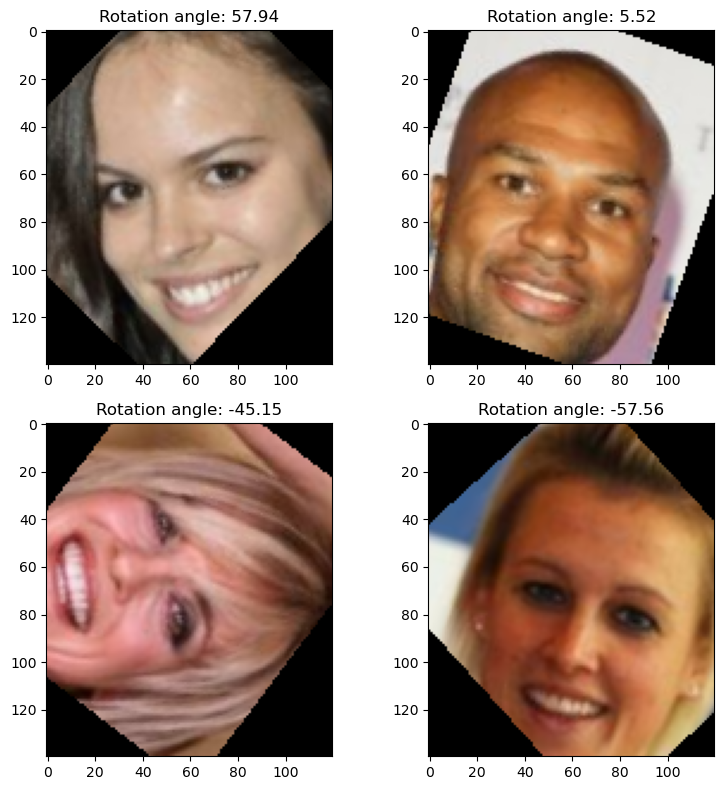

In [40]:
# get 4 image+label tuples from the train_rot_ds dataset
image_batch = train_rot_ds.take(4)

# create a 2x2 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

# iterate over the image batch and plot each image in a subplot
for i, (image, label) in enumerate(image_batch):
    #rotate the image
    rotated_image = tf.keras.preprocessing.image.random_rotation(image.numpy(), 
                                                                 60, 
                                                                 row_axis=0, 
                                                                 col_axis=1, 
                                                                 channel_axis=2, 
                                                                 fill_mode='constant')


    # plot the rotated image in a subplot with the rotation angle as the title
    axs[i//2, i%2].imshow(rotated_image)
    axs[i//2, i%2].set_title("Rotation angle: {:.2f}".format(label.numpy()))

plt.tight_layout()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1.3</b>

<a id="q213"></a>

**2.1.3** **Conceptual Question.** Dropout layers have been shown to work well for regularizing deep neural networks, and can be used with very little computational cost. For our network, is it a good idea to use dropout layers? Explain, in **3-5 sentences**, being sure to explicitly discuss how a dropout layer works, and what that would mean for our model.

Dropout layers are a form of regularization that randomly drops out (i.e., sets to zero) a certain proportion of the neurons in the layer during training. This has the effect of reducing overfitting by preventing the network from relying too heavily on any one particular set of features. In terms of the mathematical arguments, during training, the dropout layer stochastically drops out the units with probability $p$, and scales up the remaining units by a factor of $1/(1-p)$ to keep the overall activation of the layer the same.

As we saw in lecture, applying dropout after convolutional layers in this case can result in losing important features and patterns that are critical for accurate tilt prediction, particularly when the tilt angles are subtle. Dropout randomly drops out units during training, which can result in some of the feature maps becoming sparse or incomplete, leading to lower accuracy.

Moreover, the use of dropout in CNNs can also reduce the representational capacity of the network, which can further hinder its ability to learn complex relationships between the features and the tilt angles in the dataset. As such, alternative regularization techniques that preserve important features and patterns such as batch normalization, weight decay, or data augmentation might be more appropriate for this specific task.

<a id="q22"></a>


<!-- BEGIN QUESTION -->

<div class='exercise'>
<b>2.2 Building and training your CNN</b>
<hr>
<a id="q221"></a>
<b>Q2.2.1 Compiling your model.</b>
    
Construct a model with multiple Conv layers and any other layers you think would help. Be certain to print your model summary as always. Feel free to experiment with architectures and number of parameters if you wish to get better performance or better training speed. You certainly don't need more than a few million parameters; we have been able to do it with substantially fewer. 
    
**Note:** Again, it is fine to attempt your own implementation of a well-known architecture, but you may not load any pre-constructed models. The network must be built layer-by-layer from your own code.
    </div>

We choose to go forward with such a model for the following reasons:

1. Convolutional layers with batch normalization: The model uses several convolutional layers, which are well-suited for image processing tasks. The use of batch normalization layers after each convolutional layer helps to stabilize and speed up the training process.

2. Multiple convolutional blocks with pooling: The model uses multiple convolutional blocks with pooling layers to learn increasingly complex features from the image. Pooling layers help to reduce the size of the output from each block, which reduces the number of parameters in the model and helps to prevent overfitting.

3. Dropout layer: The model uses a dropout layer after the fully connected layer, which helps to prevent overfitting by randomly dropping out some of the neurons during training.

4. Linear output layer: The model uses a linear output layer, which is appropriate for regression tasks like image tilt prediction.

5. Adam optimizer with low learning rate: The model uses the Adam optimizer with a low learning rate of 0.0001, which is a good choice for training deep neural networks.

**We tried training the model with and without dropout layers which is why the dropout layers are commmented out**. However, for previously mentioned reasons we choose to move forward with a model without dropout. 

In [41]:
model = tf.keras.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(140, 120, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')
])

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['mae', 'mse'])

In [42]:
# your code here
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 140, 120, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 140, 120, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_94 (Conv2D)          (None, 140, 120, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 140, 120, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 70, 60, 32)       0         
 g2D)                                                            
                                                        

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.2 Training your model</b>

<a id="q222"></a>

Train your model. Please note that the `model.fit()` argument syntax is a little different when working with Datasets instead of numpy arrays; take a look at the [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) documentation. Be sure to also pass the test data as validation data. When passing `train_rot_ds` to `fit()`, you will find it useful to use pipelines to [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the data. You can also experiment with [prefetching](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) batches/elements from the dataset, which may allow you to speed up iterations by a few percent. Finally, while dry-running and prototyping your model, you may find it useful to [take](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) a subset of the data to speed up experimentation. However, your final model MUST be trained on all the available training data! You should achieve test MSEs of less than 9, corresponding roughly to $\pm 3^\circ$ accuracy in predicting the rotations on the test set. This can be achieved in just 2-3 epochs, though you are free to train as long as you want.
    </div>

In [43]:
# your code here

# Define batch size and number of epochs
batch_size = 64
epochs = 3

# Define train and test datasets with batch size
train_dataset = train_rot_ds.batch(batch_size)
test_dataset = test_rot_ds.batch(batch_size)

In [44]:
# Train the model  
# history = model.fit(train_dataset, 
#                     epochs=epochs, 
#                     validation_data=test_dataset, 
#                     verbose=1)

In [45]:
# model.evaluate(test_dataset)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.3 Saving and loading your weights</b>

<a id="q223"></a>

Save your model weights to the path `model/your_model_name` where `your_model_name` is whatever filename prefix you want. Then reload your weights from that same path.
  - **NOTE:** If you don't intend to use it, you may leave your line of code commented out. Nothing should change if you run it after saving it though, since it will load the same weights and everything else about the model will still be in memory. If you close your notebook or restart your kernel in the future, run all the cells required to compile the model, but skip the cells that performs the fit and the save. After running the load weights cell, your previously trained model will be restored.
  - **Answer this question in a few sentences:** Suppose you save just the weights after training for a while. If you were to load the weights again and continue training, would it work? How will it be different than continuing from a full-model save?
    
**Note:** Please do *not* upload your model weights with your notebook submission.
    </div>

Saving just the weights after training will only save the learned parameters of the model and not the architecture or any other training related information such as optimizer state, training history, etc. 

If we load the weights and continue training, it would work and the model would continue learning from the point it was saved. However, there might be some differences compared to continuing from a full-model save, such as different initial optimizer state and loss function values. 

Additionally, if the architecture of the model changes between the save and reload, the weights may not be compatible and training may not be successful.

**For this question, as seen in the cell below, we have saved weights with dropout and without**. For previously mentioned reasons, we choose to save and reload the weights from the model *with* dropout. 

We tried saving both with `model.save_weights` and the `pickle` method, the latter of which worked better and didn't require us to re-specify the entire architecture. 

In [46]:
# Save model weights
#model.save_weights('models/convnet_without_dropout')

#model.save_weights('models/convnet_with_dropout')

We use this code to save the model as a whole using `pickle`. 

In [47]:
# file_name = 'convnet_without_dropout_final'


# with open(file_name, 'wb') as f:
#     pickle.dump(model, f)

# # convert the saved model file to UTF-8 encoding
# with open(file_name, 'rb') as f:
#     content = f.read()

# with open(file_name, 'wb') as f:
#     f.write(content)


We re-load it using `pickle`. 

In [48]:
# Load the saved model
file_name = 'convnet_without_dropout_final'

# Load the saved model from file
with open(file_name, 'rb') as f:
    saved_model = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-04-05 00:49:34           64
config.json                                    2023-04-05 00:49:34        12068
variables.h5                                   2023-04-05 00:49:36    102295440
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......batch_normalization_4
.........vars
............0
............1
............2
............3
......batch_normalization_5
.........vars
............0
............1
............2
...

Making sure `test_mse` < 9.

In [49]:
test_mse = saved_model.evaluate(test_dataset)[2]
assert (test_mse<9)
print('Test MSE:',test_mse)

312/312 [==============================] - 59s 185ms/step - loss: 4.3142 - mae: 1.4085 - mse: 4.3142
Test MSE: 4.314152717590332


<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2.4 Evaluating your model</b>

<a id="q224"></a>

Create a subplots grid with 4 rows and 3 columns. Each row will be a separate image from the test set (of your choice) and each column will consist of: Original Image, Predicted Straightened Image, Target Straightened Image. The title of the latter two should be the predicted rotation and the actual rotation. For example, a row should look something like the image shown below. This can be achieved using the provided function `rot_resize` to correct for the rotation predicted by your network.

![straightened face](data/straightened.png)
    
**Hint:** Your network expects its input to have an explicit 'batch' dimension (the 1st dimension). If you use `take()` to get one image from your dataset, you will need to add this extra batch dimension to it in order to pass it to `predict()`. There are several ways to do this. You can check out [this SO post](https://stackoverflow.com/questions/43017017/keras-model-predict-for-a-single-image) for some ideas.

In [50]:
# choose 4 random images from test_rot_ds
test_images = test_rot_ds.take(4)

1/1 [==============================] - 0s 18ms/step


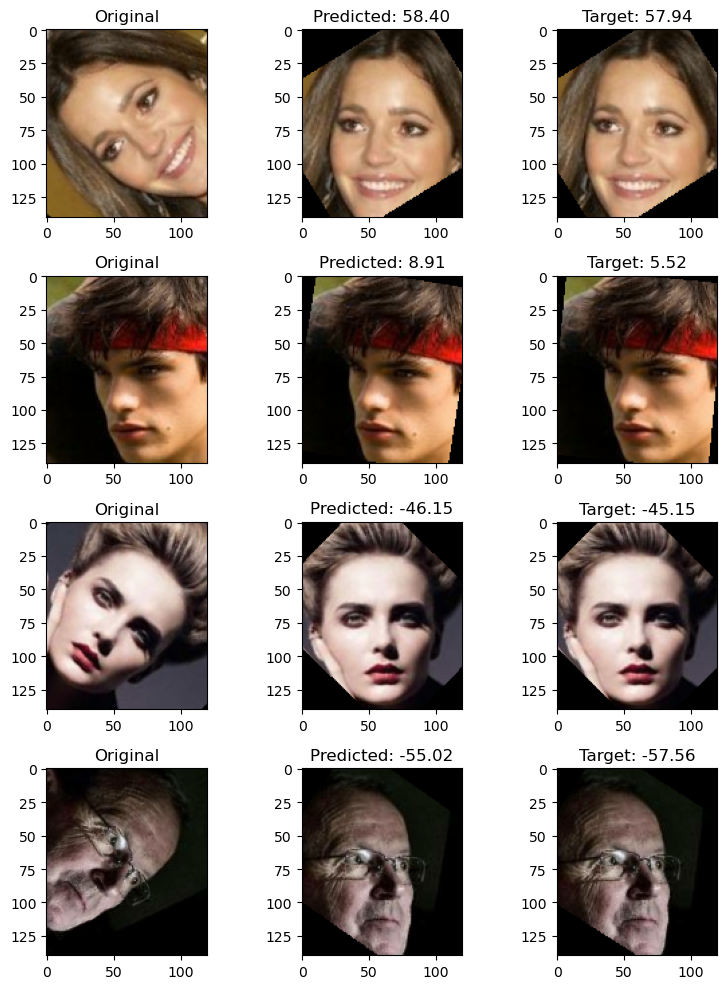

In [51]:
# create the subplots grid
fig, axs = plt.subplots(4, 3, figsize=(8, 10))

# loop through each row and plot the original, predicted, and target images
for i, (image, label) in enumerate(test_images):
    # add batch dimension to input image
    image = tf.expand_dims(image, axis=0)

    # predict the rotation using the model
    predicted_rot = saved_model.predict(image)
    #predicted_rot = predicted_rot[0][0] * 180 / np.pi
    predicted_rot = predicted_rot[0][0]

    # get the target rotation from the label
    #target_rot = label.numpy() * 180 / np.pi
    target_rot = label.numpy()

    # straighten the images using rot_resize
    orig_img = rot_resize(image[0], 0)
    #pred_img = rot_resize(image[0], -predicted_rot)
    #target_img = rot_resize(image[0], -target_rot)
    pred_img = rot_resize(image[0], -predicted_rot)
    target_img = rot_resize(image[0], -target_rot)

    # plot the images
    axs[i, 0].imshow(orig_img)
    axs[i, 0].set_title("Original")
    axs[i, 1].imshow(pred_img)
    axs[i, 1].set_title(f"Predicted: {predicted_rot:.2f}")
    axs[i, 2].imshow(target_img)
    axs[i, 2].set_title(f"Target: {target_rot:.2f}")

# adjust spacing and show plot
fig.tight_layout()

<!-- BEGIN QUESTION -->

<div class='exercise'>
<a id="q23"></a>
<b>2.3 Further Analysis</b>
<hr>
<b>Q2.3.1 Correct an image of your choosing</b>

<a id="q231"></a>

Find an image or image(s) (not from the provided test/training sets), or make your own; it does not necessarily have to be a human face. You may rotate it yourself up to $\pm60^\circ$, or the face can already be naturally rotated. Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided `normalize_image` function) and use your network to correct it.

![Confused Chris](data/chrisprattcorrection.png)
    
**Note:** Please do *not* upload your custom image as a separate file with your notebook submission. It is sufficient to display your results in the cell output.
    </div>

_Type your answer here, replacing this text._

In [57]:
# your code here

from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the image path and load the image
img_path = 'data/Bad_Luck_Brian.jpg'
img = load_img(img_path)

# Convert the image to a numpy array
img_array = img_to_array(img)

# Rotate the image by a random angle within the range of ±60 degrees
rotated_image = tf.keras.preprocessing.image.random_rotation(img_array, 60, row_axis=0, col_axis=1, channel_axis=2, fill_mode='reflect')

# Resize and crop the image to 140px by 120px
img_array = tf.image.resize_with_crop_or_pad(rotated_image, target_height=140, target_width=120)

# Normalize the image to [0.,1.]
img_array = normalize_image(img_array)

1/1 [==============================] - 0s 20ms/step


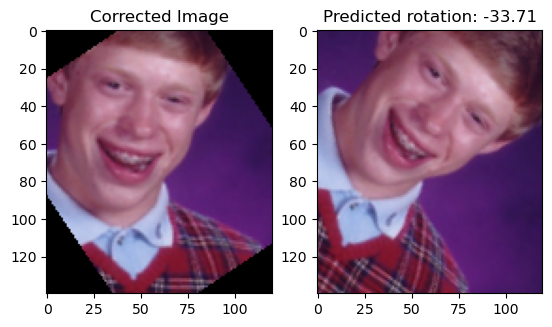

In [58]:
# Reshape the image array to match the input shape of the model
img_array_reshaped = tf.reshape(img_array, (1, 140, 120, 3))

# Use the model to predict the tilt correction angle
tilt_correction = saved_model.predict(img_array_reshaped)

tilt_correction = tilt_correction[0][0]

corrected_img_array = rot_resize(img_array, np.abs(tilt_correction))

# Display the original and corrected images side by side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(corrected_img_array)
ax[0].set_title('Corrected Image')
ax[1].imshow(img_array)
ax[1].set_title(f'Predicted rotation: {tilt_correction:.2f}')
plt.show()

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Wrap-up</b>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.
    </div>

Finding the right archictecture for the second convnet. 

In [54]:
hours_spent_on_hw = 10

In [55]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [56]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 1.33 minutes for this notebook to run


**This concludes HW4. Thank you!**